In [100]:
import numpy as np
import pandas as pd
import math 
# Modelling Helpers
from sklearn.preprocessing import Imputer , Normalizer , scale
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

In [101]:
train = pd.read_csv('train.csv' ) # Train
test = pd.read_csv('test.csv' ) # Test
test_df = test.copy()

In [102]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Features:
    PassengerId : The id given to each traveller on the boat.
    Pclass : The Passenger class. It has three possible values: 1,2,3 (first, second and third class).
    Name : The Name of the passeger.
    Sex : The Gender of the Passenger.
    Age : The Age of the Passenger.
    SibSp : The number of siblings and spouses traveling with the passenger.
    Parch : number of parents and children traveling with the passenger.
    Ticket : The ticket number of the Passenger.
    Fare : The ticket Fare of the passenger
    Cabin : The cabin number.
    Embarked : This describe three areas of the Titanic from which the people embark. Three possible values S,C,Q (Southampton, Cherbourg, Queenstown).
    Qualitative Features (Categorical) : PassengerId , Pclass , Survived , Sex , Ticket , Cabin , Embarked.

    Quantitative Features (Numerical) : SibSp , Parch , Age , Fare.

    Survival is the Target Variable.


In [103]:
train.shape

(891, 12)

In [104]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

We have null values in Age and Cabin.

In [105]:
# Look at the percentage
train.Survived.value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

#### So, out of 891 examples only 342 (38%) survived and rest all died.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


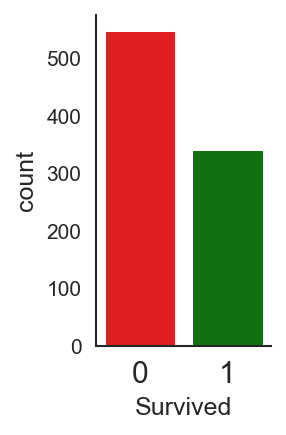

In [106]:
sns.factorplot(x='Survived' , kind='count' , data=train , palette=['r','g'] , size=3 , aspect=.6)

Let's examine the survival ratio based on Pclass to see if some people were given the priority.

In [107]:
pd.crosstab(train.Pclass , train.Survived , margins=True)

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


In [108]:
train[['Pclass' , 'Survived']].groupby('Pclass').mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


#### The trend of decreasing survival rate can be clearly seen on the basis of Pclass. Therefore, we see that high class were given more priority.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


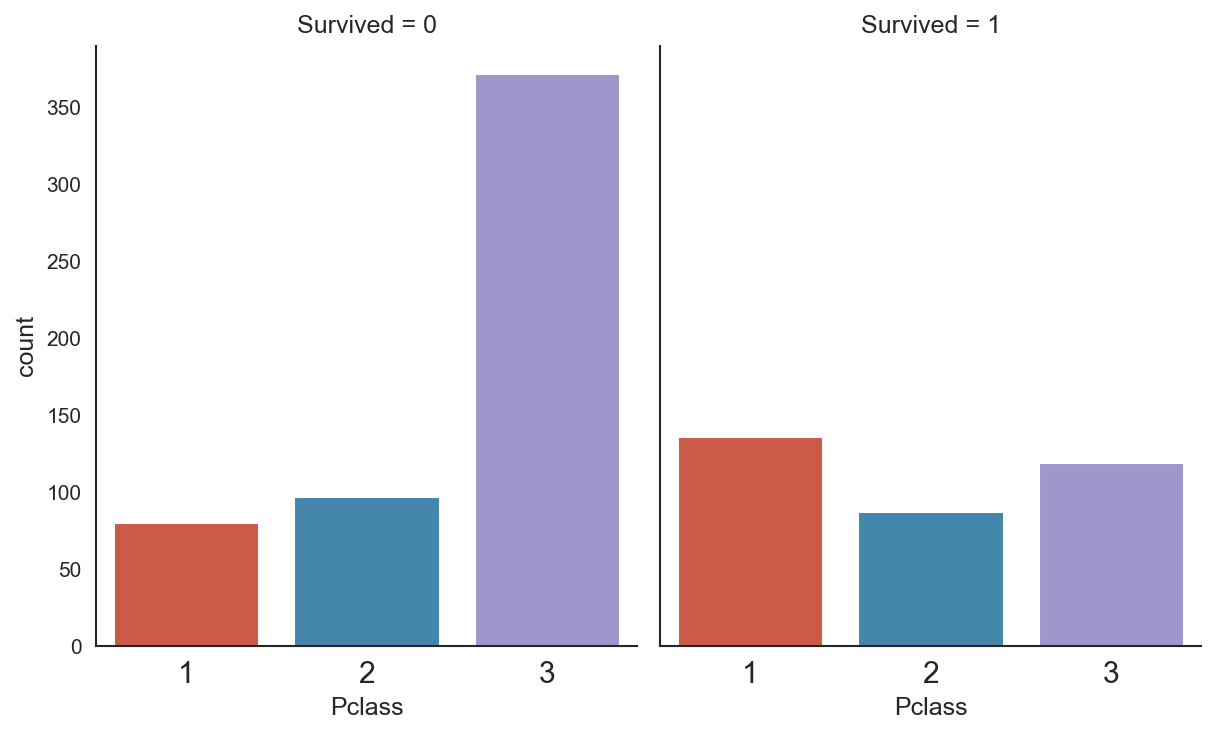

In [109]:
sns.factorplot(x='Pclass' , data=train , col='Survived' , kind='count' , size=5 , aspect=.8)

#### Let's see if there was a preference based on gender in saving lives

In [110]:
pd.crosstab(train.Sex , train.Survived , margins=True,normalize='index')

Survived,0,1
Sex,,
female,0.257962,0.742038
male,0.811092,0.188908
All,0.616162,0.383838


#### We can see that clearly ratio of survival of female to men is almost 3:1.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


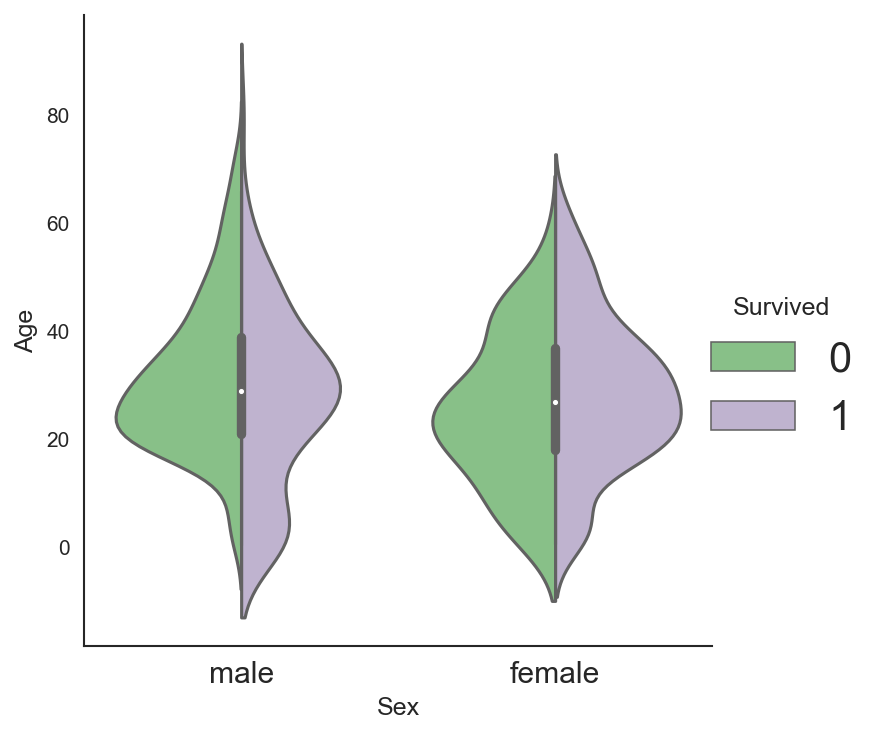

In [111]:
sns.factorplot(x='Sex' , y='Age' , data=train , hue='Survived' , kind='violin' , palette='Accent' , split=True)

We can see that Males have Surviving Density less than Females (Bulged) . And majority of those who survived belonged to the category of Age limit 20-30 . Same is true for the Death Scenario.

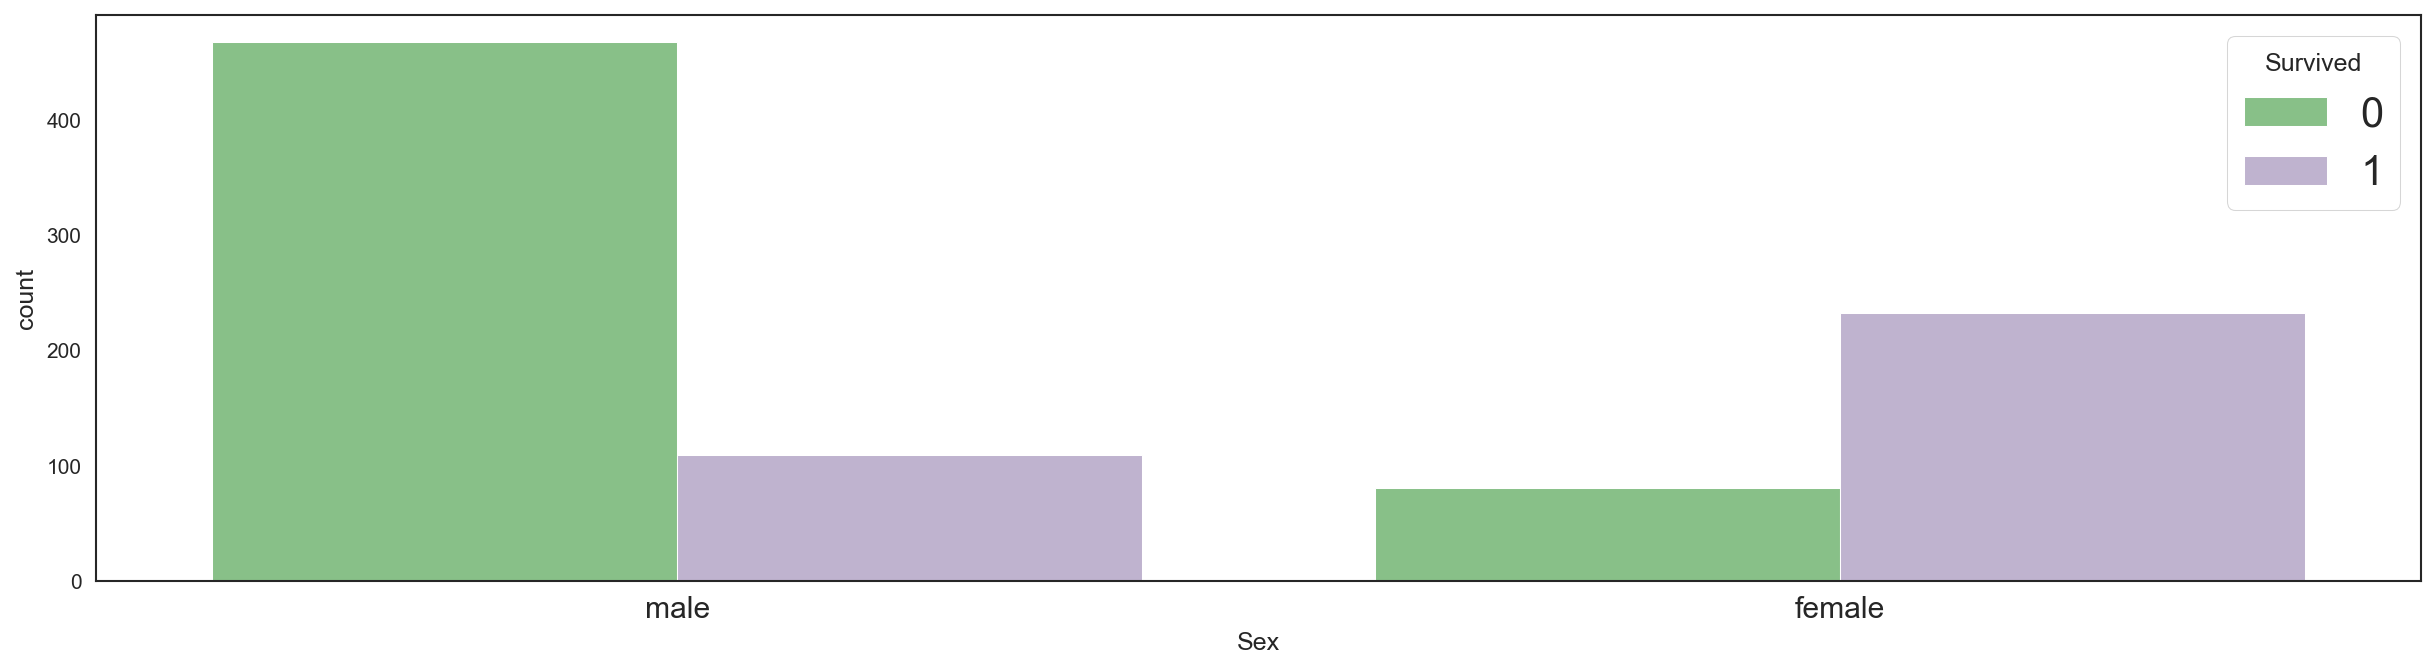

In [112]:
sns.countplot(x='Sex',data=train,hue='Survived',palette='Accent')

#### The above graph is a clear indication of above results.

#### Now for examining age, we need to first impute it...

In [113]:
train['Age']=train['Age'].fillna(train['Age'].median())

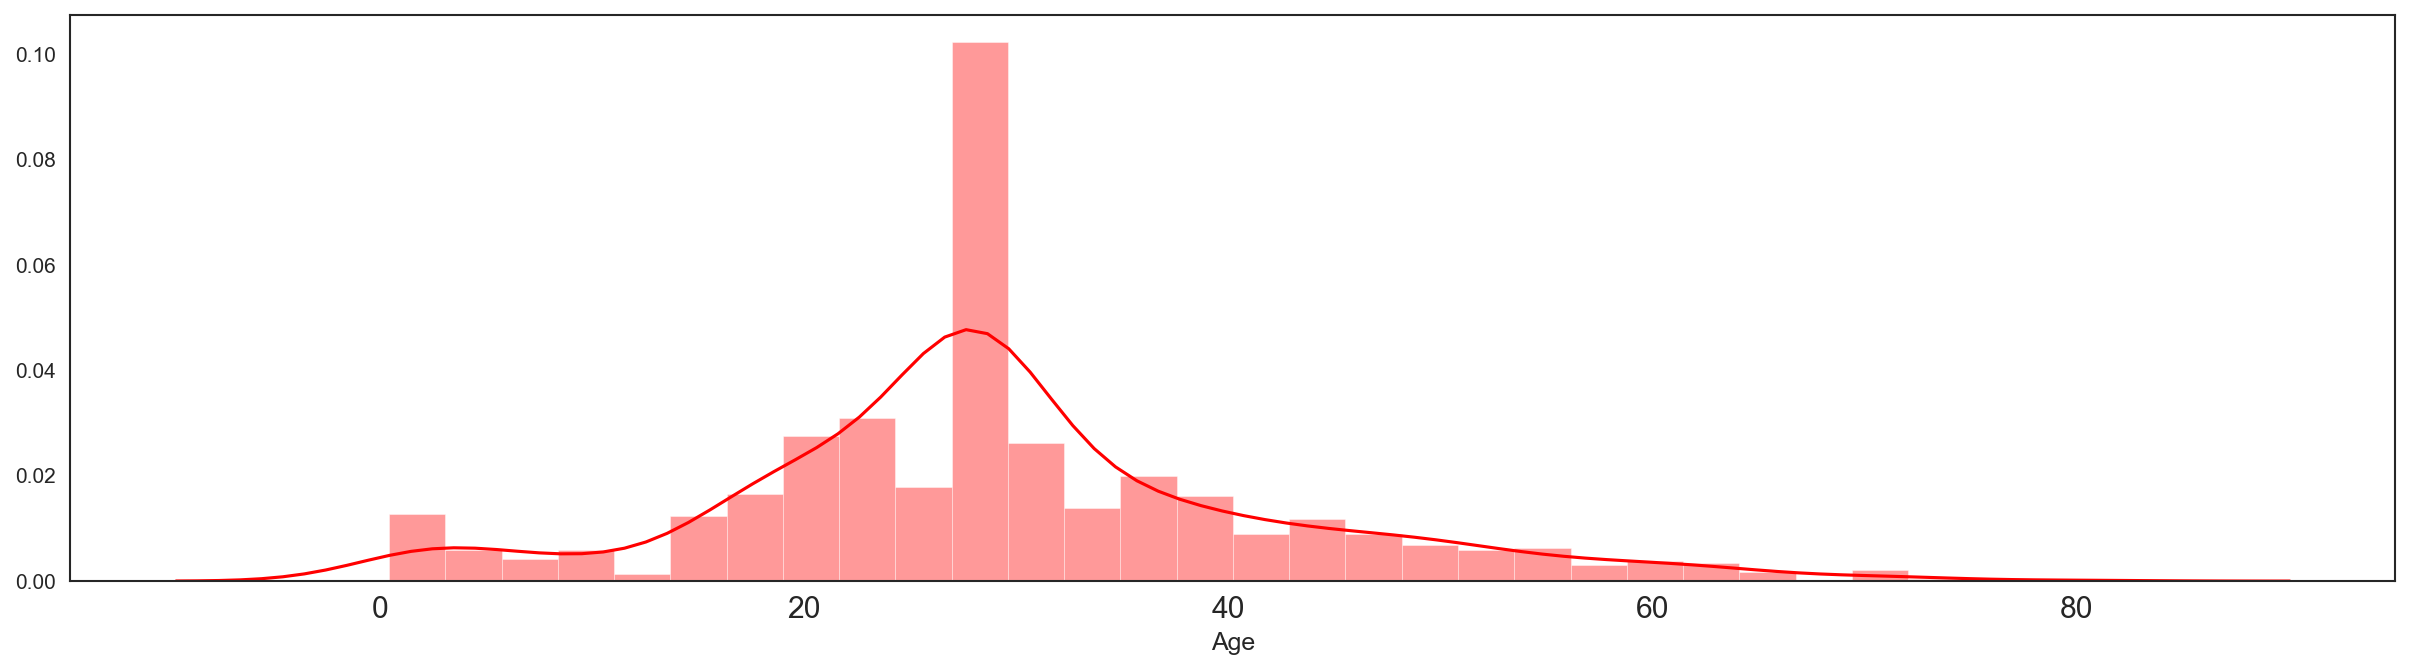

In [114]:
sns.distplot(train.Age , color='r')

#### I used median to fill empty points because of the outliers present in it. We can also infer that most of the people were close to age 30.

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


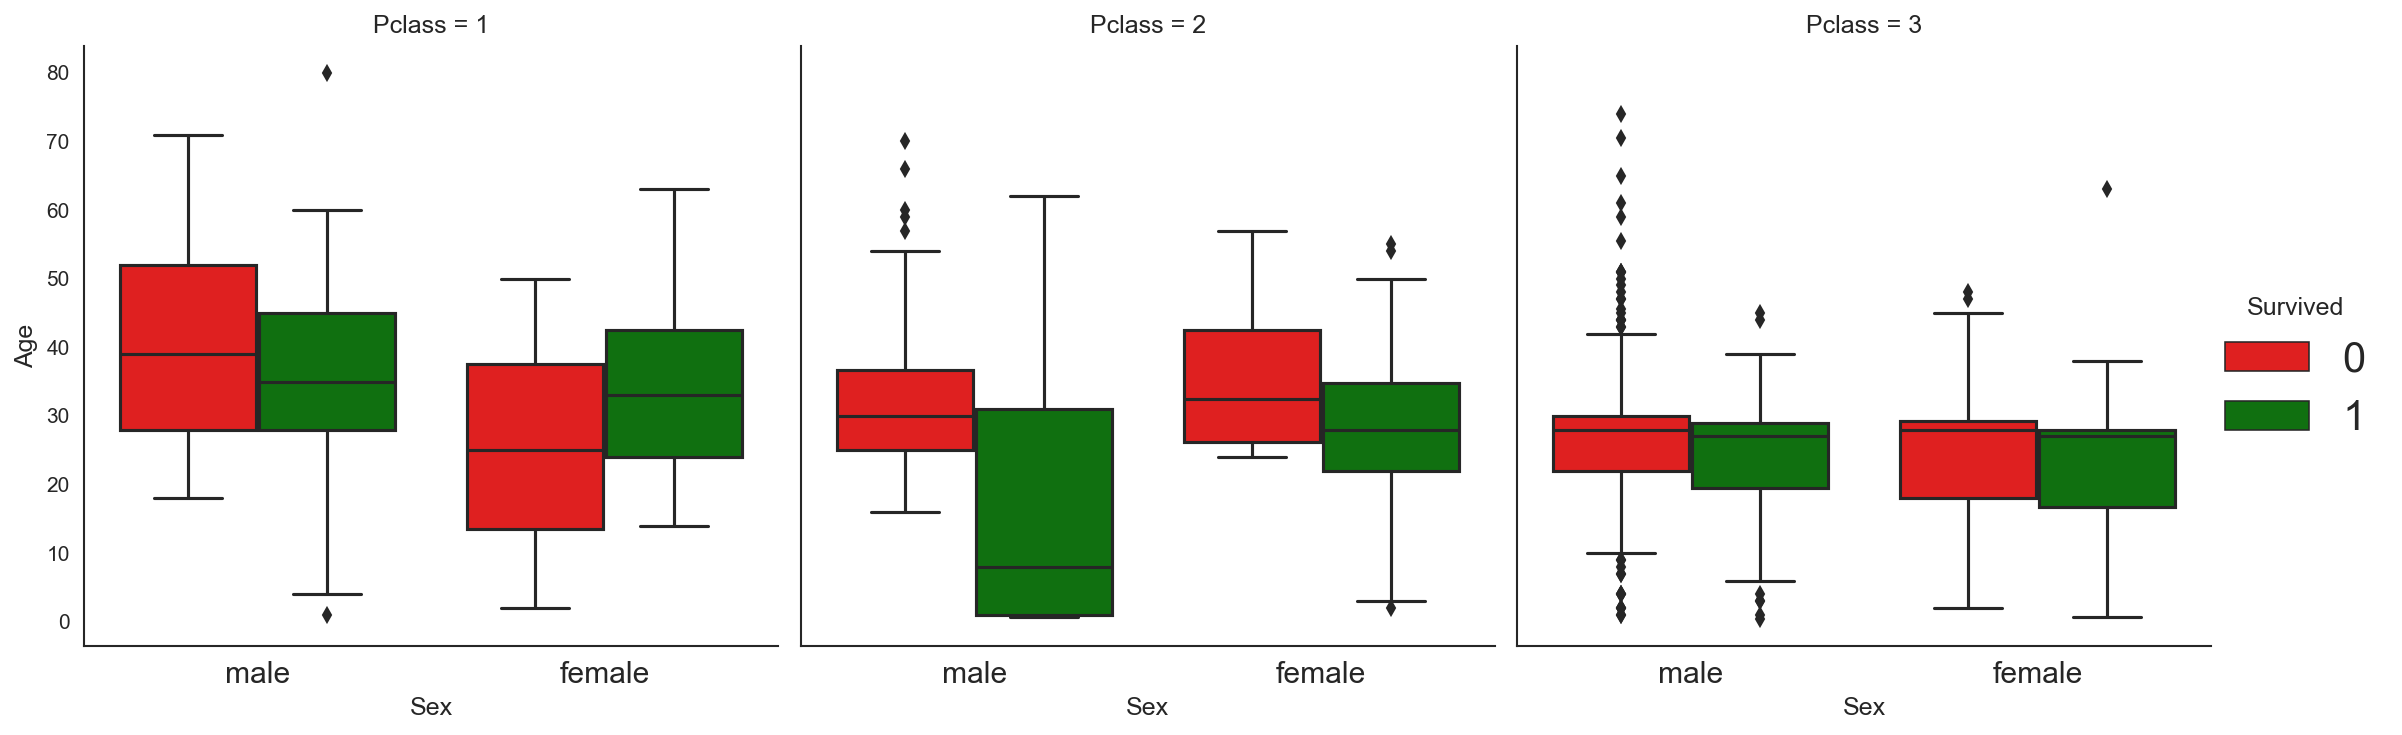

In [119]:
sns.factorplot(x='Sex',y='Age' , col='Pclass', data=train , hue='Survived' , kind = 'box', palette=['r','g'])

We can see that net survival is more in Pclass 1 as discussed earlier and minimum in Pclass3.

#### Some more insights:
    Many men (younger in age) in Pclass2 survived and the number was even more than the women.
    It seems that the passengers of class3 belong to a particular age group only.
    But there do exist some extreme outliers.

### Let's see if fare has some impact..

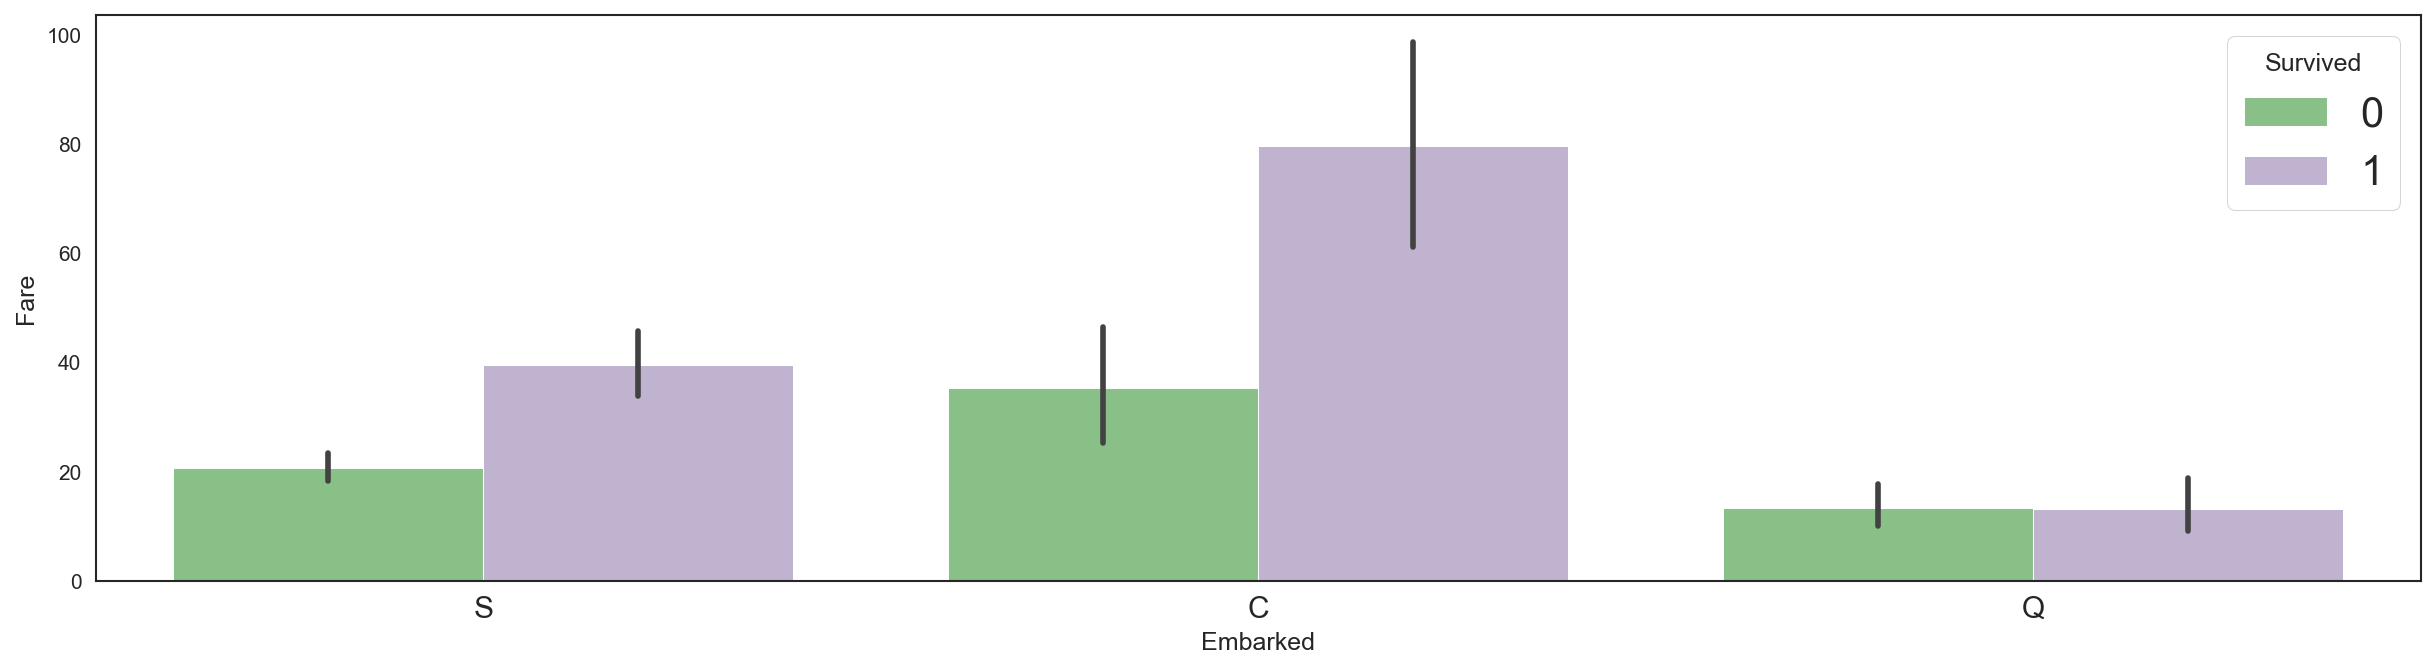

In [126]:
sns.barplot(train['Embarked'] , y =train['Fare'] ,hue=train['Survived'],palette='Accent')

#### We can see that those who paid high were likely to Survive.

##### To study embarked we need to first impute it..

In [127]:
train['Embarked'].fillna(train['Embarked'].mode()[0],inplace=True)

In [128]:
pd.crosstab([train.Sex,train.Survived] , [train.Pclass,train.Embarked] , margins=True)

Pclass            1           2           3           All
Embarked          C  Q    S   C  Q    S   C   Q    S     
Sex    Survived                                          
female 0          1  0    2   0  0    6   8   9   55   81
       1         42  1   48   7  2   61  15  24   33  233
male   0         25  1   51   8  1   82  33  36  231  468
       1         17  0   28   2  0   15  10   3   34  109
All              85  2  129  17  3  164  66  72  353  891

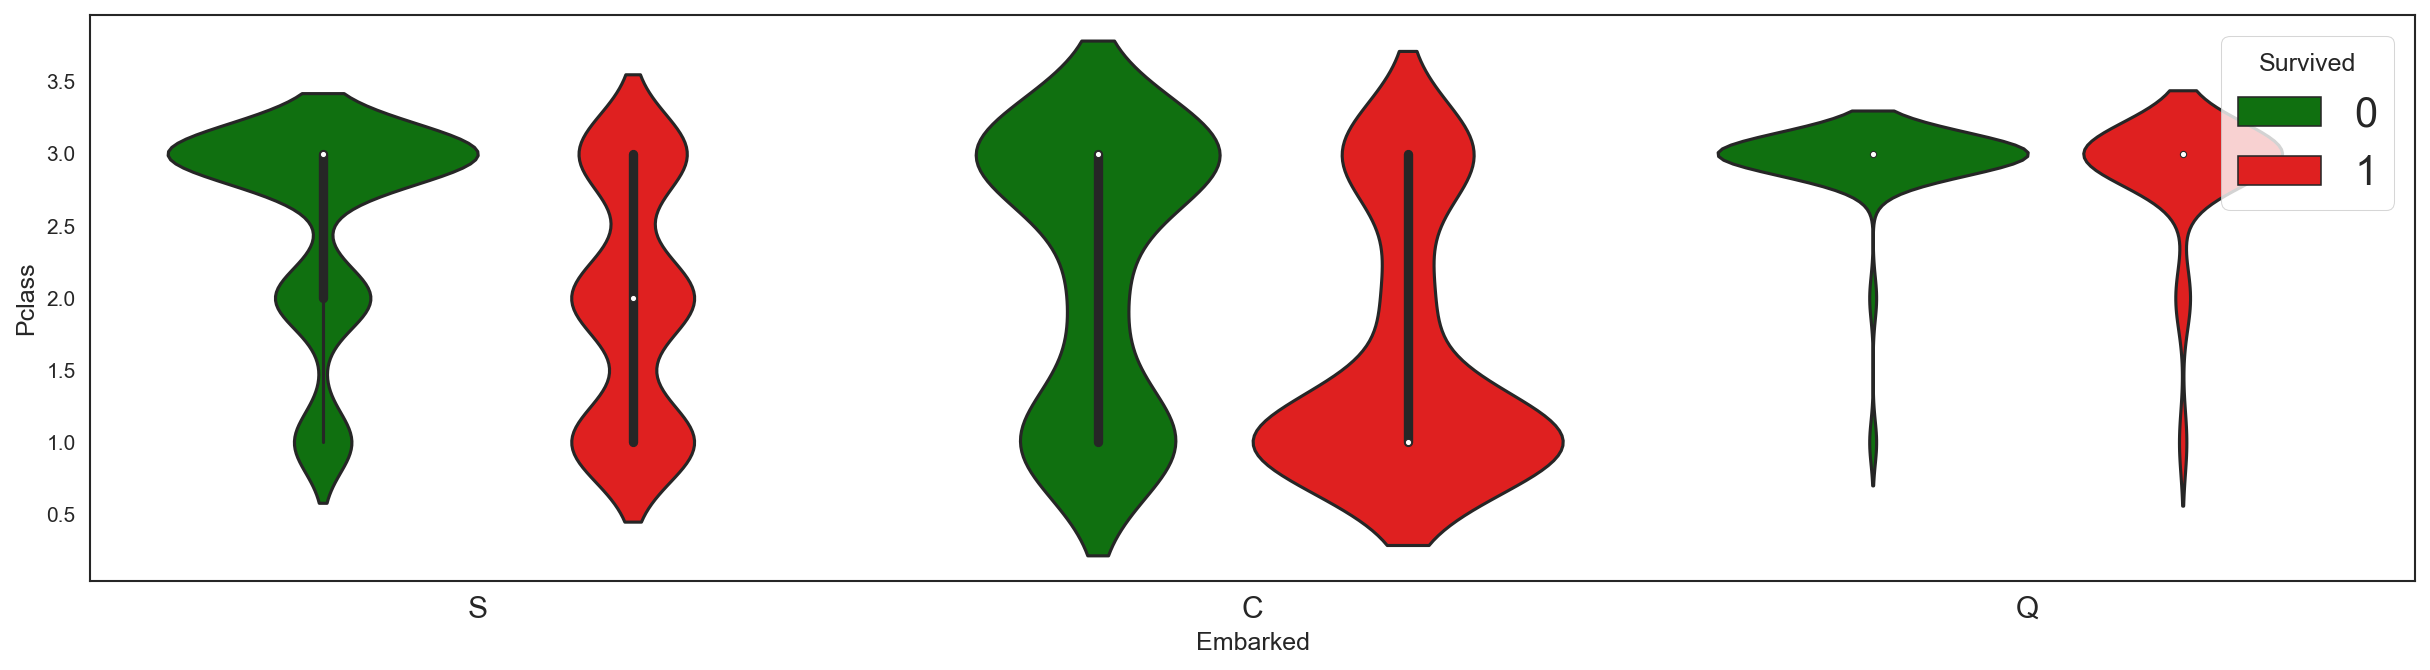

In [130]:
sns.violinplot(x='Embarked' , y='Pclass' , data=train , hue='Survived' , palette=['g','r'])

#### We can see that those who embarked at C with First Class ticket had a good chance of Survival. Whereas for S, it seems that all classes had nearly equal probability of Survival. And for Q, third Class seems to have Survived and Died with similar probabilities.

### Let's examine on the basis of Siblings..

In [131]:
train[['SibSp' , 'Survived']].groupby('SibSp').mean()

,Survived
SibSp,
0,0.345395
1,0.535885
2,0.464286
3,0.250000
4,0.166667
5,0.000000
8,0.000000


#### It seems that there individuals having 1 or 2 siblings/spouses had the highest Probability of Survival, followed by individuals who were Alone.

### Now let's examine Parch

In [132]:
train[['Parch','Survived']].groupby('Parch').mean()

,Survived
Parch,
0,0.343658
1,0.550847
2,0.500000
3,0.600000
4,0.000000
5,0.200000
6,0.000000


#### It seems that individuals with 1,2 or 3 family members had a greater Probability of Survival, followed by individuals who were Alone.

Looking at Parch and SibSp, we can see that individuals having Family Members had a slightly greater chance of Survival.
